In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio

In [2]:
vidpath = 'cat.mp4'

In [3]:
# prompt: load a single frame of a video file

def load_single_frame(video_path, frame_number):
  """Loads a single frame from a video file.

  Args:
    video_path: Path to the video file.
    frame_number: The frame number to load (0-indexed).

  Returns:
    A NumPy array representing the frame, or None if the frame
    number is invalid or the file cannot be opened.
  """
  try:
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
      print(f"Error opening video file: {video_path}")
      return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if not 0 <= frame_number < total_frames:
      print(f"Invalid frame number: {frame_number}. Total frames: {total_frames}")
      return None

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        print(f"Error reading frame {frame_number}")
        return None
  except Exception as e:
    print(f"An error occurred: {e}")
    return None


Click in the window to select TOP‑LEFT, TOP‑RIGHT, BOTTOM‑RIGHT, BOTTOM‑LEFT (in that order).
Selected corners (row, col):
[[  91  332]
 [ 105 1514]
 [1044 1507]
 [1058  336]]


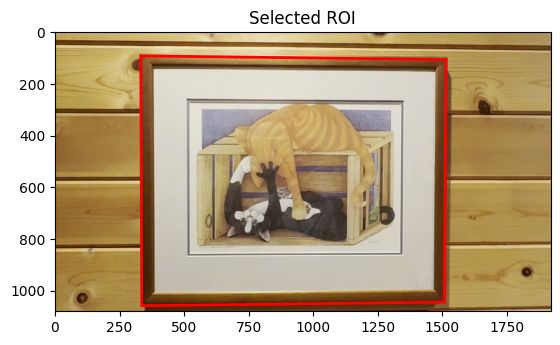

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your first frame as before
frame0 = load_single_frame(vidpath, 0)   # shape (H, W, 3), RGB in [0,1]

# Prepare for interactive picking
points = []
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
        points.append((x, y))
        # draw a small circle so you see your click
        cv2.circle(frame_disp, (x, y), 5, (0, 255, 0), -1)

# Convert to BGR uint8 for cv2 display
frame_disp = cv2.cvtColor((frame0 * 255).astype('uint8'), cv2.COLOR_RGB2BGR)
win = "Select 4 corners: TL → TR → BR → BL"
cv2.namedWindow(win)
cv2.setMouseCallback(win, mouse_callback)

print("Click in the window to select TOP‑LEFT, TOP‑RIGHT, BOTTOM‑RIGHT, BOTTOM‑LEFT (in that order).")

# Show window and wait until 4 clicks
while True:
    cv2.imshow(win, frame_disp)
    if len(points) == 4:
        break
    # small delay so CPU isn’t pegged
    if cv2.waitKey(50) & 0xFF == 27:  # allow Esc to abort early
        break

cv2.destroyAllWindows()

# Convert collected (x,y) to (row, col) array
corners = np.array([[y, x] for (x, y) in points])  # shape (4,2)

print("Selected corners (row, col):")
print(corners)

# ──────── 2. REST OF THE PIPELINE (unchanged) ────────
# width = horizontal span (x‑axis = column index)
width  = int(max(abs(corners[1,1] - corners[0,1]),   # top edge
                 abs(corners[2,1] - corners[3,1])))  # bottom edge

# height = vertical span (y‑axis = row index)
height = int(max(abs(corners[3,0] - corners[0,0]),   # left edge
                 abs(corners[2,0] - corners[1,0])))  # right edge

rectcorners = np.array([[0, 0],
                        [0, width],
                        [height, width],
                        [height, 0]])


H0C, _ = cv2.findHomography(corners[:, ::-1],   # col,row order
                            rectcorners[:, ::-1],
                            cv2.RANSAC)

# visualize the region you picked
plt.imshow(frame0)
plt.fill(corners[:,1], corners[:,0],
         edgecolor='red', lw=2, facecolor='none')
plt.title("Selected ROI")
plt.show()


In [5]:
# Rectify Original Image
def rectify(img, incorners, outcorners):
  outsize = (outcorners[2, 1], outcorners[2, 0])
  H, m = cv2.findHomography(incorners[:,::-1], outcorners[:,::-1], cv2.RANSAC) # uses col,row order
  outimg = cv2.warpPerspective(img, H, outsize)
  return outimg

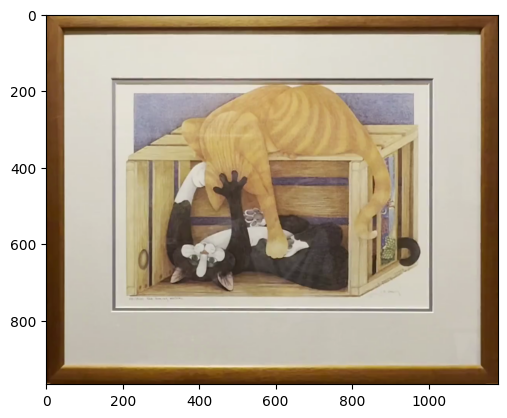

In [6]:
# show original rectified image
refimg = rectify(frame0, corners, rectcorners)
plt.imshow(refimg)
plt.show()

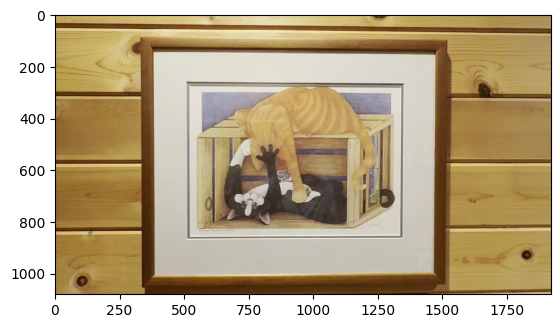

In [10]:
# load another frame
frame1 = load_single_frame(vidpath, 0)
frame2 = load_single_frame(vidpath,80)
plt.imshow(frame1)
plt.show()

In [8]:
print(corners)
# --- after you have `corners` (row, col) -----------------------------
row0 = int(corners[:, 0].min())           # ROW  (y)
col0 = int(corners[:, 1].min())           # COL  (x)

roi_h = int(corners[:, 0].max() - row0)   # height  (rows)
roi_w = int(corners[:, 1].max() - col0)   # width   (cols)

# slice the true patch
frame0_roi   = frame0[row0:row0 + roi_h, col0:col0 + roi_w]

# 128×128 template in *float32 [0,1]*
template_128 = cv2.resize(frame0_roi, (128, 128),
                          interpolation=cv2.INTER_LINEAR).astype(np.float32) / 255.0

# lift: ROI → template (u,v ∈ [0,127])
sy, sx = 128.0 / roi_h, 128.0 / roi_w
S_ROIT = np.array([[sx, 0,  -sx * col0],
                   [0,  sy, -sy * row0],
                   [0,   0,          1]], dtype=np.float32)


[[  91  332]
 [ 105 1514]
 [1044 1507]
 [1058  336]]


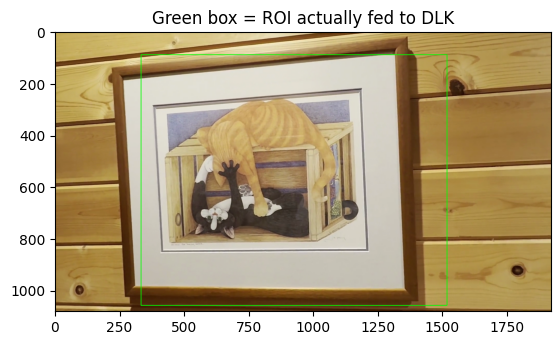

: 

In [ ]:
# Visual check: overlay cropped ROI on frame‑0
test = frame2.copy()
cv2.rectangle(test,
              (int(col0), int(row0)),
              (int(col0+roi_w), int(row0+roi_h)),
              (0,255,0), 2)
plt.imshow(test); plt.title("Green box = ROI actually fed to DLK"); plt.show()



In [10]:
def find_homography(img0, img1):
  gray0 = cv2.cvtColor(img0, cv2.COLOR_RGB2GRAY)
  gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

  orb = cv2.ORB_create()
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

  kp0, des0 = orb.detectAndCompute(gray0, None)
  kp1, des1 = orb.detectAndCompute(gray1, None)

  matches = bf.match(des0, des1)
  matches = sorted(matches, key = lambda x:x.distance)

  src_pts = np.float32([kp0[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
  des_pts = np.float32([kp1[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

  H, m = cv2.findHomography(src_pts, des_pts, cv2.RANSAC, 5.0)

  return H

In [11]:
def homography(src, dst):
    gray_s = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
    gray_d = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)

    orb  = cv2.ORB_create()
    kp_s, des_s = orb.detectAndCompute(gray_s, None)
    kp_d, des_d = orb.detectAndCompute(gray_d, None)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(des_s, des_d)
    matches = sorted(matches, key=lambda x: x.distance)

    pts_s = np.float32([kp_s[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    pts_d = np.float32([kp_d[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    H, _ = cv2.findHomography(pts_s, pts_d, cv2.RANSAC, 5.0)
    return H

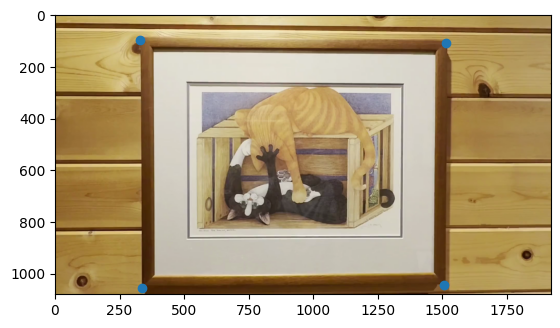

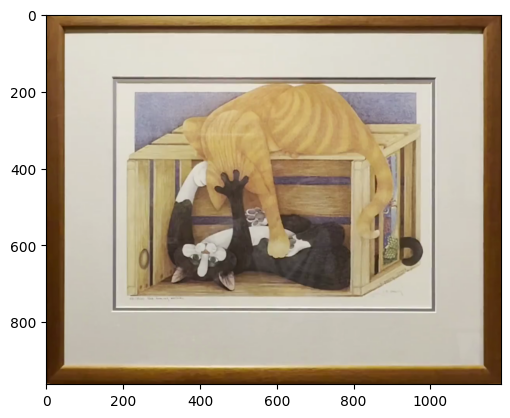

In [12]:
# warp new frame to rectified space
H = find_homography(refimg, frame1)

# change to both xy and column format
newcorners = cv2.perspectiveTransform(np.float32(rectcorners[:, ::-1].reshape(-1, 1, 2)), H)

# show new corners
plt.imshow(frame1)
plt.scatter(newcorners[:,:,0], newcorners[:,:,1])
plt.show()

# show rectified image
rectimg = rectify(frame1, newcorners, rectcorners)
plt.imshow(rectimg)
plt.show()

In [13]:
import sys
sys.path.append('../')
from data_read import *
from net import *
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import tensorflow as tf
parser = argparse.ArgumentParser()


parser.add_argument('--dataset_name', action="store", dest= "dataset_name",default="MSCOCO",help='MSCOCO,GoogleMap,GoogleEarth,DayNight')


parser.add_argument('--epoch_load_one', action="store", dest="epoch_load_one", type=int, default=3,help='epoch_load_one')


parser.add_argument('--epoch_load_two', action="store", dest="epoch_load_two", type=int, default=3,help='epoch_load_two')

parser.add_argument('--epoch_load_three', action="store", dest="epoch_load_three", type=int, default=3,help='epoch_load_three')

parser.add_argument('--num_iters', action="store", dest="num_iters", type=int, default=20,help='num_iters')

parser.add_argument('--feature_map_type', action="store", dest="feature_map_type", default='special',help='regular or special')

parser.add_argument('--initial_type', action="store", dest="initial_type", default='multi_net',help='vanilla, simple_net, multi_net')

parser.add_argument('--load_epoch_simplenet', action="store", dest="load_epoch_simplenet", default=50,help='load_epoch_simplenet')

parser.add_argument('--load_epoch_multinet', action="store", dest="load_epoch_multinet", default=[50,50,40],help='load_epoch_multinet')


input_parameters = parser.parse_args([])



gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)



def construct_matrix_regression(batch_size,network_output,network_output_2=[0]):
    extra=tf.ones((batch_size,1))
    predicted_matrix=tf.concat([network_output,extra],axis=-1)
    predicted_matrix=tf.reshape(predicted_matrix,[batch_size,3,3])
    if len(np.shape(network_output_2))>1:
        predicted_matrix_2=tf.concat([network_output_2,extra],axis=-1)
        predicted_matrix_2=tf.reshape(predicted_matrix_2,[batch_size,3,3])
    hh_matrix=[]
    for i in range(batch_size):
        if len(np.shape(network_output_2))>1:
            hh_matrix.append(np.linalg.inv(np.dot(predicted_matrix_2[i,:,:],predicted_matrix[i,:,:])))
        else:
            hh_matrix.append(np.linalg.inv(predicted_matrix[i,:,:]))
        #hh_matrix.append(predicted_matrix[i,:,:])
    
    #return tf.linalg.inv(predicted_matrix+0.0001)
    return np.asarray(hh_matrix)

def initial_motion_COCO():
    # prepare source and target four points
    matrix_list=[]
    for i in range(1):
       
        src_points=[[0,0],[127,0],[127,127],[0,127]]

        tgt_points=[[32,32],[160,32],[160,160],[32,160]]

    
        src_points=np.reshape(src_points,[4,1,2])
        tgt_points=np.reshape(tgt_points,[4,1,2])

        # find homography
        h_matrix, status = cv2.findHomography(src_points, tgt_points,0)
        matrix_list.append(h_matrix)
    return np.asarray(matrix_list).astype(np.float32)


def construct_matrix(initial_matrix,scale_factor,batch_size):
    #scale_factor size_now/(size to get matrix)
    initial_matrix=tf.cast(initial_matrix,dtype=tf.float32)
    
    scale_matrix=np.eye(3)*scale_factor
    scale_matrix[2,2]=1.0
    scale_matrix=tf.cast(scale_matrix,dtype=tf.float32)
    scale_matrix_inverse=tf.linalg.inv(scale_matrix)

    scale_matrix=tf.expand_dims(scale_matrix,axis=0)
    scale_matrix=tf.tile(scale_matrix,[batch_size,1,1])

    scale_matrix_inverse=tf.expand_dims(scale_matrix_inverse,axis=0)
    scale_matrix_inverse=tf.tile(scale_matrix_inverse,[batch_size,1,1])

    final_matrix=tf.matmul(tf.matmul(scale_matrix,initial_matrix),scale_matrix_inverse)
    return final_matrix



def average_cornner_error(batch_size,predicted_matrix,u_list,v_list,top_left_u=0,top_left_v=0,bottom_right_u=127,bottom_right_v=127):
    
    four_conner=[[top_left_u,top_left_v,1],[bottom_right_u,top_left_v,1],[bottom_right_u,bottom_right_v,1],[top_left_u,bottom_right_v,1]]
    four_conner=np.asarray(four_conner)
    four_conner=np.transpose(four_conner)
    four_conner=np.expand_dims(four_conner,axis=0)
    four_conner=np.tile(four_conner,[batch_size,1,1]).astype(np.float32)
    
    new_four_points=tf.matmul(predicted_matrix,four_conner)
    
    new_four_points_scale=new_four_points[:,2:,:]
    new_four_points= new_four_points/new_four_points_scale
    
    
    u_predict=new_four_points[:,0,:]
    v_predict=new_four_points[:,1,:]
    
    average_conner=tf.reduce_mean(tf.sqrt(tf.math.pow(u_predict-u_list,2)+tf.math.pow(v_predict-v_list,2)))

    
    
    return average_conner
    

def calculate_feature_map(input_tensor):
    bs,height,width,channel=tf.shape(input_tensor)
    path_extracted=tf.image.extract_patches(input_tensor, sizes=(1,3,3,1), strides=(1,1,1,1), rates=(1,1,1,1), padding='SAME')
    path_extracted=tf.reshape(path_extracted,(bs,height,width,channel,9))
    path_extracted_mean=tf.math.reduce_mean(path_extracted,axis=3,keepdims=True)

    #path_extracted_mean=tf.tile(path_extracted_mean,[1,1,1,channel,1])
    path_extracted=path_extracted-path_extracted_mean
    path_extracted_transpose=tf.transpose(path_extracted,(0,1,2,4,3))
    variance_matrix=tf.matmul(path_extracted_transpose,path_extracted)
    
    tracevalue=tf.linalg.trace(variance_matrix)
    row_sum=tf.reduce_sum(variance_matrix,axis=-1)
    max_row_sum=tf.math.reduce_max(row_sum,axis=-1)
    min_row_sum=tf.math.reduce_min(row_sum,axis=-1)
    mimic_ratio=(max_row_sum+min_row_sum)/2.0/tracevalue
    
    return  tf.expand_dims(mimic_ratio,axis=-1)


if input_parameters.feature_map_type=='regular':
    load_path_one='./checkpoints/'+input_parameters.dataset_name+'/level_one_regular/'

    load_path_two='./checkpoints/'+input_parameters.dataset_name+'/level_two_regular/'

    load_path_three='./checkpoints/'+input_parameters.dataset_name+'/level_three_regular/'

    level_one_input=ResNet_first_input(if_regular=True)
    level_one_template=ResNet_first_template(if_regular=True)
    level_two_input=ResNet_second_input(if_regular=True)
    level_two_template=ResNet_second_template(if_regular=True)
    level_three_input=ResNet_third_input(if_regular=True)
    level_three_template=ResNet_third_template(if_regular=True)

elif input_parameters.feature_map_type=='special':

    load_path_one='./checkpoints/'+input_parameters.dataset_name+'/level_one/'

    load_path_two='./checkpoints/'+input_parameters.dataset_name+'/level_two/'

    load_path_three='./checkpoints/'+input_parameters.dataset_name+'/level_three/'

    level_one_input=ResNet_first_input()
    level_one_template=ResNet_first_template()
    level_two_input=ResNet_second_input()
    level_two_template=ResNet_second_template()
    level_three_input=ResNet_third_input()
    level_three_template=ResNet_third_template()


level_one_input.load_weights(load_path_one + 'epoch_'+str(input_parameters.epoch_load_one)+"input_full")

level_one_template.load_weights(load_path_one + 'epoch_'+str(input_parameters.epoch_load_one)+"template_full")

level_two_input.load_weights(load_path_two + 'epoch_'+str(input_parameters.epoch_load_two)+"input_full")

level_two_template.load_weights(load_path_two  + 'epoch_'+str(input_parameters.epoch_load_two)+"template_full")

level_three_input.load_weights(load_path_three + 'epoch_'+str(input_parameters.epoch_load_three)+"input_full")

level_three_template.load_weights(load_path_three  + 'epoch_'+str(input_parameters.epoch_load_three)+"template_full")


if input_parameters.initial_type=='vanilla':
    initial_matrix=initial_motion_COCO()
    initial_matrix=construct_matrix(initial_matrix,scale_factor=0.25,batch_size=1)

if input_parameters.initial_type=='simple_net':
    save_path_regression='./checkpoints/'+input_parameters.dataset_name+'/regression_stage_1/'
    regression_network=Net_first()
    regression_network.load_weights(save_path_regression + 'epoch_'+str(input_parameters.load_epoch_simplenet))

if input_parameters.initial_type=='multi_net':
    save_path_one='./checkpoints/'+input_parameters.dataset_name+'/regression_stage_1/'
    save_path_two='./checkpoints/'+input_parameters.dataset_name+'/regression_stage_2/'
    save_path_three='./checkpoints/'+input_parameters.dataset_name+'/regression_stage_3/'
    regression_network_one=Net_first()
    regression_network_one.load_weights(save_path_one + 'epoch_'+str(input_parameters.load_epoch_multinet[0]))
    regression_network_two=Net_second()
    regression_network_two.load_weights(save_path_two + 'epoch_'+str(input_parameters.load_epoch_multinet[1]))
    regression_network_three=Net_third()
    regression_network_three.load_weights(save_path_three + 'epoch_'+str(input_parameters.load_epoch_multinet[2]))
    

LK_layer_one=Lucas_Kanade_layer(batch_size=1,height_template=128,width_template=128,num_channels=1)

LK_layer_two=Lucas_Kanade_layer(batch_size=1,height_template=64,width_template=64,num_channels=1)

LK_layer_three=Lucas_Kanade_layer(batch_size=1,height_template=32,width_template=32,num_channels=1)


LK_layer_regression=Lucas_Kanade_layer(batch_size=1,height_template=192,width_template=192,num_channels=3)


if input_parameters.dataset_name=='MSCOCO':
    data_loader_caller=data_loader_MSCOCO('val')

if input_parameters.dataset_name=='GoogleMap':
    data_loader_caller=data_loader_GoogleMap('val')

if input_parameters.dataset_name=='GoogleEarth':
    data_loader_caller=data_loader_GoogleEarth('val')

if input_parameters.dataset_name=='DayNight':
    data_loader_caller=data_loader_DayNight('val')

1 Physical GPUs, 1 Logical GPUs


2025-07-18 21:38:49.659440: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-07-18 21:38:49.659460: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-07-18 21:38:49.659463: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-07-18 21:38:49.659521: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-18 21:38:49.659706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


6387


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from skimage.transform import resize 

# Load and Initially Normalize Images (as done in data_read.py for MSCOCO)
try:
    raw_input_img = frame2/255.0
    raw_template_img = frame1/255.0
    print(f"Loaded original input image shape: {raw_input_img.shape}")
    print(f"Loaded original template image shape: {raw_template_img.shape}")

except FileNotFoundError:
    print("Error: One or both of your image files were not found. Please check the paths.")
    # You might want to exit here or handle the error gracefully
    exit()
except Exception as e:
    print(f"An unexpected error occurred while loading images: {e}")
    exit()

# Ensure images have 3 channels (RGB) if they were loaded as grayscale (2D)
if raw_input_img.ndim == 2:
    raw_input_img = np.stack([raw_input_img]*3, axis=-1)
if raw_template_img.ndim == 2:
    raw_template_img = np.stack([raw_template_img]*3, axis=-1)

# Resize Images to Expected Dimensions for the Pipeline
# Input: 192x192, Template: 128x128 (as per model expectations in Visualization.ipynb)
target_input_dim = (192, 192)
target_template_dim = (128, 128)

input_img_resized = resize(raw_input_img, target_input_dim, anti_aliasing=True)
template_img_resized = resize(raw_template_img, target_template_dim, anti_aliasing=True)

print(f"Resized input image for feature extraction shape: {input_img_resized.shape}")
print(f"Resized template image for feature extraction shape: {template_img_resized.shape}")

# Convert NumPy arrays to TensorFlow tensors and add a batch dimension (for a single image).
input_img_tf_batch = tf.expand_dims(tf.convert_to_tensor(input_img_resized, dtype=tf.float32), axis=0)
template_img_tf_batch = tf.expand_dims(tf.convert_to_tensor(template_img_resized, dtype=tf.float32), axis=0)

# Prepare Images for Initial Regression Network
template_img_padded_for_regression = tf.image.pad_to_bounding_box(template_img_tf_batch, 32, 32, 192, 192)

input_img_grey_for_regression = tf.image.rgb_to_grayscale(input_img_tf_batch)
template_img_grey_for_regression = tf.image.rgb_to_grayscale(template_img_padded_for_regression)

# This tensor is the direct input to the initial regression networks.
network_input_for_regression_models = tf.concat([template_img_grey_for_regression, input_img_grey_for_regression], axis=-1)

print(f"Shape of prepared input for regression models: {network_input_for_regression_models.shape}")

# --- Ground Truth Labels for Error Calculation ---
# ⚠️ If you want to calculate 'average_cornner_error', you MUST define the ground truth
#    corner points for your manually added images here.
#    These should be 4 (u,v) pairs for the template in the input image's coordinate system.
#    Example: [[u1,v1],[u2,v2],[u3,v3],[u4,v4]]
#    If you don't have ground truth, the 'average_cornner_error' part will not be accurate or will fail.
#    For now, we'll use placeholder lists so the code can run without error,
#    but these won't result in meaningful error if not replaced with actual data.
u_list_manual = np.array([[0, 127, 127, 0]]) # Placeholder for u-coordinates of 4 corners
v_list_manual = np.array([[0, 0, 127, 127]]) # Placeholder for v-coordinates of 4 corners

# --- END OF YOUR MANUAL IMAGE LOADING AND PREPROCESSING CODE ---

# --- MODIFIED PIPELINE EXECUTION ---
# Modify the outer loop to run only once for your single manual input.
# Also, remove the data_loader_caller.data_read_batch call and the break condition.
total_error = 0.0    
fk_loop = input_parameters.num_iters

# Loop runs only once for manual image processing
for iters in range(1):
    # Map your manually loaded images to the variables used in the original notebook.
    # input_img and template_img here are the RGB images with a batch dimension.
    input_img = input_img_tf_batch
    template_img = template_img_tf_batch
    # Use your manual u_list and v_list for error calculation.
    u_list = u_list_manual
    v_list = v_list_manual
    if input_parameters.initial_type=='simple_net':
        input_img_grey=tf.image.rgb_to_grayscale(input_img)
        template_img_new=tf.image.pad_to_bounding_box(template_img, 32, 32, 192, 192)  
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new)    
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector=regression_network.call(network_input,training=False)
        extra=tf.ones((1,1))
        initial_matrix=tf.concat([homography_vector,extra],axis=-1)
        initial_matrix=tf.reshape(initial_matrix,[1,3,3])
        initial_matrix=construct_matrix(initial_matrix,scale_factor=0.25,batch_size=1)

    if input_parameters.initial_type=='multi_net':
        input_img_grey=tf.image.rgb_to_grayscale(input_img)
        template_img_new=tf.image.pad_to_bounding_box(template_img, 32, 32, 192, 192)  
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new)
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector_one=regression_network_one.call(network_input,training=False)
        matrix_one=construct_matrix_regression(1,homography_vector_one)
        template_img_new=LK_layer_regression.projective_inverse_warp(tf.dtypes.cast(template_img,tf.float32), matrix_one)
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new) 
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector_two=regression_network_two.call(network_input,training=False)
        matrix_two=construct_matrix_regression(1,homography_vector_one,homography_vector_two)
        template_img_new=LK_layer_regression.projective_inverse_warp(tf.dtypes.cast(template_img,tf.float32), matrix_two)
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new)  
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector_three=regression_network_three.call(network_input,training=False)

        extra=tf.ones((1,1))
        initial_matrix=tf.concat([homography_vector_three,extra],axis=-1)
        initial_matrix=tf.reshape(initial_matrix,[1,3,3])
        initial_matrix=np.dot(initial_matrix[0,:,:], np.linalg.inv(matrix_two[0,:,:]))
        initial_matrix=np.expand_dims(initial_matrix,axis=0)
        initial_matrix=construct_matrix(initial_matrix,scale_factor=0.25,batch_size=1)





        
    input_feature_one=level_one_input.call(input_img,training=False)
    template_feature_one=level_one_template.call(template_img,training=False)

    input_feature_two=level_two_input.call(input_feature_one,training=False)
    template_feature_two=level_two_template.call(template_feature_one,training=False)

    input_feature_three=level_three_input.call(input_feature_two,training=False)
    template_feature_three=level_three_template.call(template_feature_two,training=False)


    if input_parameters.feature_map_type=='regular':
        input_feature_map_one=input_feature_one
        template_feature_map_one=template_feature_one

        input_feature_map_two=input_feature_two
        template_feature_map_two=template_feature_two

        input_feature_map_three=input_feature_three
        template_feature_map_three=template_feature_three

    elif input_parameters.feature_map_type=='special':
                
        input_feature_map_one=calculate_feature_map(input_feature_one)
        template_feature_map_one=calculate_feature_map(template_feature_one)

        input_feature_map_two=calculate_feature_map(input_feature_two)
        template_feature_map_two=calculate_feature_map(template_feature_two)

        input_feature_map_three=calculate_feature_map(input_feature_three)
        template_feature_map_three=calculate_feature_map(template_feature_three)
        
        
    updated_matrix=initial_matrix
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_three.update_matrix(template_feature_map_three,input_feature_map_three,updated_matrix)
        except:
            print ('s')

    updated_matrix=construct_matrix(updated_matrix,scale_factor=2.0,batch_size=1)
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_two.update_matrix(template_feature_map_two,input_feature_map_two,updated_matrix)
        except:
            print ('s')
            
    updated_matrix=construct_matrix(updated_matrix,scale_factor=2.0,batch_size=1)
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_one.update_matrix(template_feature_map_one,input_feature_map_one,updated_matrix)
        except:
            print ('s')



    predicted_matrix=updated_matrix



    cornner_error=average_cornner_error(1,predicted_matrix,u_list,v_list,top_left_u=0,top_left_v=0,bottom_right_u=127,bottom_right_v=127)

    
    print (float(cornner_error))
    print(predicted_matrix)


Loaded original input image shape: (1080, 1920, 3)
Loaded original template image shape: (1080, 1920, 3)
Resized input image for feature extraction shape: (192, 192, 3)
Resized template image for feature extraction shape: (128, 128, 3)
Shape of prepared input for regression models: (1, 192, 192, 2)
54.65565490722656
tf.Tensor(
[[[ 1.4991302e+00 -6.2168197e-04  1.4197236e-01]
  [-3.6531941e-03  1.4969704e+00  3.4699807e-01]
  [-1.9947543e-05 -1.1461786e-05  1.0000000e+00]]], shape=(1, 3, 3), dtype=float32)


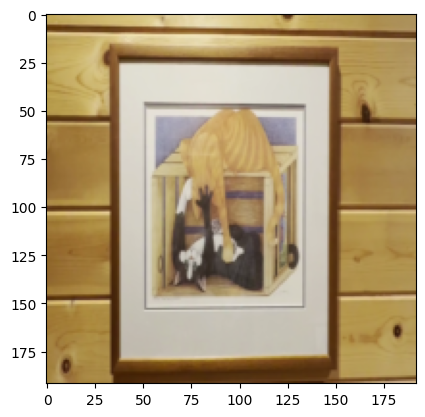

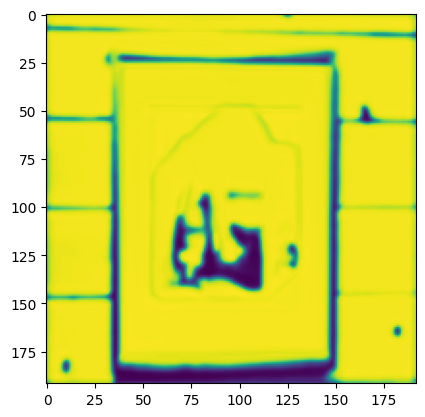

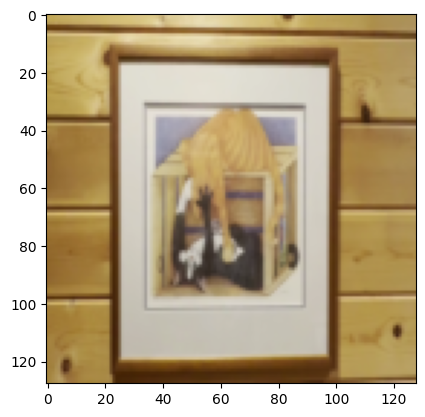

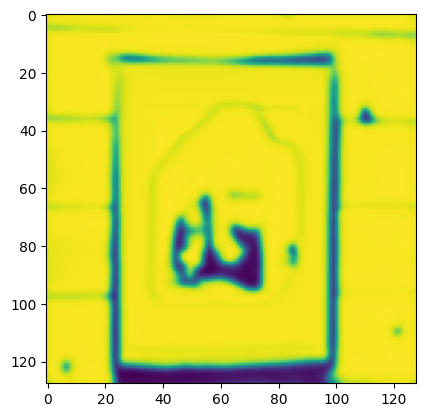

In [15]:
plt.imshow(input_img[0,:,:,:])
plt.show()
plt.imshow(input_feature_map_one[0,:,:,0])
plt.show()
plt.imshow(template_img[0,:,:,:])
plt.show()
plt.imshow(template_feature_map_one[0,:,:,0])
plt.show()

In [17]:
final_homography_matrix = H0C @ np.linalg.inv(predicted_matrix)
print(final_homography_matrix)

[[[ 6.39952931e-01 -6.20188292e-03 -3.19183828e+02]
  [-6.22855036e-03  6.53822587e-01 -9.00189957e+01]
  [-1.22033148e-06 -5.18669302e-07  1.00000037e+00]]]


In [ ]:
outimg = cv2.warpPerspective(frame2, final_homography_matrix, (500,500))

error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/imgwarp.cpp:3399: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 3 && M0.cols == 3 in function 'warpPerspective'


: 

In [ ]:
incr       = 1
frame_ixs  = range(0, 233, incr)
error      = np.zeros(len(frame_ixs))
imgs       = np.zeros([len(frame_ixs), height, width, 3])

for i, fi in enumerate(frame_ixs):
    if i % 10 == 0: print('.')
    frame_k = load_single_frame(vidpath, fi)      # full RGB, 0‑1

    # ── DLK homography template128 → frame_k ───────────
    H_Tk = dlk_homography(frame_k)

    # ── Lift into frame0‑ROI coords ────────────────────
    H_0k = H_Tk @ S_ROIT          # frame0‑ROI → frame_k

    # ── Compose to canonical ───────────────────────────
    H_kC = H0C @ np.linalg.inv(H_0k)

    # warp and compute error exactly as before
    rect_k = cv2.warpPerspective(frame_k, H_kC, (width, height))
    error[i] = np.mean(np.abs(rect_k/255.0 - refimg/255.0))
    imgs[i]  = rect_k


.
.
.
.
.


InvalidArgumentError: {{function_node __wrapped__MatrixInverse_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is not invertible. [Op:MatrixInverse] name: 

: 

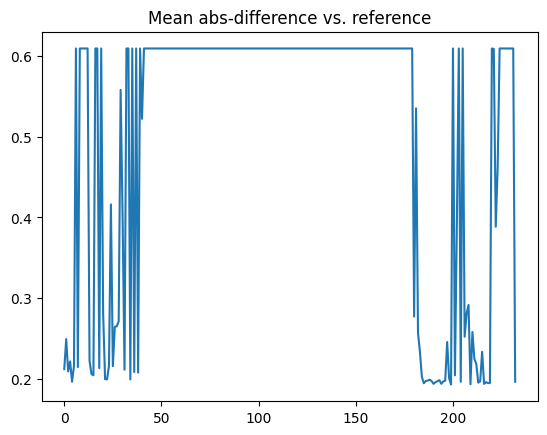

In [28]:
plt.plot(error)
plt.title("Mean abs‑difference vs. reference")
plt.show()

In [29]:
import cv2, numpy as np

height, width = imgs[0].shape[:2]
fps      = 30
out_path = "rectified_video.mp4"
fourcc   = cv2.VideoWriter_fourcc(*"mp4v")

writer = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

for idx, frame in enumerate(imgs):
    print(f"Writing frame {idx + 1}/{len(imgs)}")
    bgr = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    writer.write(bgr)

writer.release()
print("✓  Video written to", out_path)


Writing frame 1/233
Writing frame 2/233
Writing frame 3/233
Writing frame 4/233
Writing frame 5/233
Writing frame 6/233
Writing frame 7/233
Writing frame 8/233
Writing frame 9/233
Writing frame 10/233
Writing frame 11/233
Writing frame 12/233
Writing frame 13/233
Writing frame 14/233
Writing frame 15/233
Writing frame 16/233
Writing frame 17/233
Writing frame 18/233
Writing frame 19/233
Writing frame 20/233
Writing frame 21/233
Writing frame 22/233
Writing frame 23/233
Writing frame 24/233
Writing frame 25/233
Writing frame 26/233
Writing frame 27/233
Writing frame 28/233
Writing frame 29/233
Writing frame 30/233
Writing frame 31/233
Writing frame 32/233
Writing frame 33/233
Writing frame 34/233
Writing frame 35/233
Writing frame 36/233
Writing frame 37/233
Writing frame 38/233
Writing frame 39/233
Writing frame 40/233
Writing frame 41/233
Writing frame 42/233
Writing frame 43/233
Writing frame 44/233
Writing frame 45/233
Writing frame 46/233
Writing frame 47/233
Writing frame 48/233
W